In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)
from itertools import cycle
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [3]:

def evaluate_lstm(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_):
    return evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, 'LSTM')

def display_and_save(name, plot):
    fig = plot.get_figure()
    #fig.savefig("result_plots/{}.eps".format(name.replace(":","").strip()), format='eps', dpi=1000)
    fig.savefig("result_plots/{}.png".format(name.replace(":","").strip()), format='png', dpi=1000)
    display(plot)

def evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, model_type='AE'):
    all_scenarios = pd.DataFrame(columns=['Scenarios', 'Number of Features', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Duration(secs)'])
    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='f1_score', ascending=False)
        return df
    
    def get_result(past_scores):
            
        df = get_best_df(past_scores)
        
        #epoch_nof_hidden
        key = int(df.iloc[0]['epoch'])
        nof = int(df.iloc[0].name[0])
        hidden = int(df.iloc[0].name[1])
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores):
        _, _, df = get_result(past_scores)
        display(name)
        display(df)
        
        group_by = 'no_of_features'
        if(model_type == 'LSTM'):
            group_by = 'hidden_layers'
        df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=[group_by])
        
        df1 = df1.first().loc[:,['f1_score', 'f1_score_20', 'time_taken']]
        df1 = df1.rename(index={1:"One", 12:"10%", 24:"20%", 48:"40%", 122:"All"})
        df1 = df1.rename(columns={"f1_score":"F1(Test+)", "f1_score_20":"F1(Test-)", "time_taken":"Duration(secs)"})
        plot = df1.plot(secondary_y = 'Duration(secs)', title=name)#,figsize=(10, 10))
        display_and_save(name, plot)
        
    def plot_auc(y_true, y_pred):
        y_true = y_true.astype(type(""))
        y_pred = y_pred.astype(type(""))
        
        y_true_oh = pd.get_dummies(y_true).values
        y_pred_oh = pd.get_dummies(y_pred, categories = [0,1]).values
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in [0,1]:
            fpr[i], tpr[i], _ = me.roc_curve(y_true_oh[:,i], y_pred_oh[:,i])
            roc_auc[i] = me.auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = me.roc_curve(y_true_oh.ravel(), y_pred_oh.ravel())
        roc_auc["micro"] = me.auc(fpr["micro"], tpr["micro"])
        plt.figure()
        lw = 2
        colors = cycle(['aqua', 'cornflowerblue'])
        for i, color in zip([0,1], colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve for {0} (area = {1:0.2f})'
                     ''.format("Normal" if i == 0 else "Attack", roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        display(plt.show())
     
        
    #display("Individual Results for each Scenario")    
    view_data("Results for {} Train+".format(model),past_scores)
    view_data("Results for {} Train-".format(model),past_scores_20)
        
    def get_score(y_true, y_pred):
        f1 = me.f1_score(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        #plot_auc(y_true, y_pred)
        return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    
    def accumulate_scenarios(predictions, past_scores):
        key, nof, df = get_result(past_scores)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        scores = get_score(y_true, y_pred)
        scores.update({"Model":model,"Scenarios":scenario,"Number of Features":nof, "Duration(secs)":df.iloc[0]['time_taken']})
        
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Train+/Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores))
    
    scenario = "Train+/Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_, past_scores))
    
    scenario = "Train-/Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20, past_scores_20))
    
    scenario = "Train-/Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20_, past_scores_20))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))
    
    return all_scenarios
    
    
    
    

In [4]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")


'Results for FCN Train+'

epoch  f1_score  f1_score_20  test_score  \
no_of_features hidden_layers                                             
48.0           3.0               12    0.8739       0.8350      0.8670   
24.0           1.0                4    0.8728       0.8316      0.8672   
122.0          3.0                3    0.8684       0.8410      0.8516   
               1.0                4    0.8628       0.8240      0.8524   
12.0           3.0               12    0.8571       0.8392      0.8305   
48.0           1.0                6    0.8547       0.8065      0.8472   
12.0           1.0               12    0.8372       0.7851      0.8333   
24.0           3.0                4    0.8266       0.7657      0.8219   
1.0            1.0               12    0.7492       0.6508      0.7586   
               3.0                2    0.0000       0.0000      0.4308   

                              test_score_20  time_taken  train_score  
no_of_features hidden_layers                                          
48.0           3.0                   0.7576     18.9799       0.9247  
24.0           1.0                   0.7557      6.6152       0.9070  
122.0          3.0                   0.7478      4.3544       0.8601  
               1.0                   0.7338      7.7877       0.9166  
12.0           3.0                   0.7302     16.9951       0.8019  
48.0           1.0                   0.7156      5.8756       0.9138  
12.0           1.0                   0.6966     10.9119       0.8978  
24.0           3.0                   0.6672     10.2749       0.9105  
1.0            1.0                   0.5460     10.8948       0.9336  
               3.0                   0.1816      1.5907       0.5299

'Results for FCN Train-'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
48             1                  2       0.8468      0.8561    0.8695   
24             1                 10       0.8841      0.8450    0.8480   
122            3                  5       0.8746      0.8274    0.8364   
               1                 12       0.8849      0.7988    0.7890   
12             3                 12       0.8575      0.7296    0.7044   
               1                 12       0.8881      0.7312    0.7013   
48             3                 12       0.8877      0.7040    0.6553   
24             3                 12       0.8175      0.6853    0.6223   
1              1                 12       0.7762      0.5603    0.3772   
               3                  2       0.5512      0.4308    0.0000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             1                     0.7504       0.8396      0.6421  
24             1                     0.7114       0.7952      5.3462  
122            3                     0.6828       0.7840      3.9727  
               1                     0.6268       0.7104      5.9950  
12             3                     0.5021       0.5874      8.0408  
               1                     0.5036       0.5794      5.7757  
48             3                     0.4484       0.5050      8.7694  
24             3                     0.4194       0.4563      8.3999  
1              1                     0.3158       0.2880      5.7566  
               3                     0.1816       0.0000      0.8571

'Combined Results from all Scenarios for FCN'

Accuracy  Duration(secs)  F1 Score  \
Model Scenarios    Number of Features                                       
FCN   Train+/Test+ 48                    0.8670         18.9799    0.8739   
      Train+/Test- 48                    0.7576         18.9799    0.8350   
      Train-/Test+ 48                    0.8561          0.6421    0.8695   
      Train-/Test- 48                    0.7504          0.6421    0.8396   

                                       Precision  Recall  
Model Scenarios    Number of Features                     
FCN   Train+/Test+ 48                     0.9490  0.8098  
      Train+/Test- 48                     0.9424  0.7495  
      Train-/Test+ 48                     0.8988  0.8420  
      Train-/Test- 48                     0.8856  0.7981

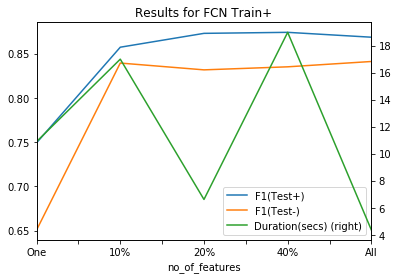

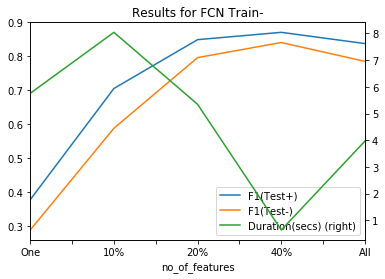

In [5]:
all_scenarios_fcn = evaluate("FCN", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [6]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-__.pkl")

'Results for VAE-Softmax Train+'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
122            3                 14       0.8919      0.8948    0.9036   
12             3                 13       0.9060      0.8857    0.8991   
24             3                  9       0.9124      0.8799    0.8903   
12             1                  2       0.9076      0.8424    0.8512   
1              3                  7       0.7804      0.7750    0.7918   
               1                 10       0.8485      0.7631    0.7549   
48             3                  9       0.8450      0.7485    0.7320   
24             1                  2       0.8893      0.7514    0.7301   
122            1                  2       0.7534      0.5653    0.3830   
48             1                  2       0.5329      0.4308    0.0000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
122            3                     0.8173       0.8814     88.6219  
12             3                     0.7967       0.8743     40.3995  
24             3                     0.7912       0.8643     27.2753  
12             1                     0.7108       0.8049      1.8614  
1              3                     0.7089       0.8054     19.0764  
               1                     0.6047       0.6993     14.5744  
48             3                     0.5669       0.6515     28.7957  
24             1                     0.5343       0.6196      1.9091  
122            1                     0.2329       0.1202      2.6863  
48             1                     0.1816       0.0000      2.0868

'Results for VAE-Softmax Train-'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
48             3                  8       0.8865      0.8884    0.8975   
12             3                 32       0.7831      0.8480    0.8741   
24             3                  4       0.9095      0.8608    0.8715   
48             1                  2       0.9149      0.8122    0.8152   
1              3                 32       0.7922      0.7862    0.8001   
               1                  5       0.7740      0.7897    0.7904   
24             1                  3       0.8649      0.7921    0.7843   
12             1                  2       0.8152      0.7488    0.7416   
122            3                  2       0.8774      0.7500    0.7368   
               1                  2       0.5370      0.4308    0.0000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             3                     0.8015       0.8700     10.4086  
12             3                     0.7747       0.8692     41.8303  
24             3                     0.7559       0.8393      4.2602  
48             1                     0.6474       0.7488      1.3026  
1              3                     0.6639       0.7782     39.1019  
               1                     0.7082       0.8001      2.7128  
24             1                     0.6361       0.7250      2.0652  
12             1                     0.5691       0.6769      0.8530  
122            3                     0.5752       0.6601      1.7788  
               1                     0.1816       0.0000      1.6425

'Combined Results from all Scenarios for VAE-Softmax'

Accuracy  Duration(secs)  \
Model       Scenarios    Number of Features                             
VAE-Softmax Train+/Test+ 122                   0.8948         88.6219   
            Train+/Test- 122                   0.8173         88.6219   
            Train-/Test+ 48                    0.7195         10.4086   
            Train-/Test- 48                    0.8015         10.4086   

                                             F1 Score  Precision  Recall  
Model       Scenarios    Number of Features                               
VAE-Softmax Train+/Test+ 122                   0.9036     0.9441  0.8665  
            Train+/Test- 122                   0.8814     0.9402  0.8296  
            Train-/Test+ 48                    0.6942     0.9151  0.5592  
            Train-/Test- 48                    0.8700     0.9373  0.8118

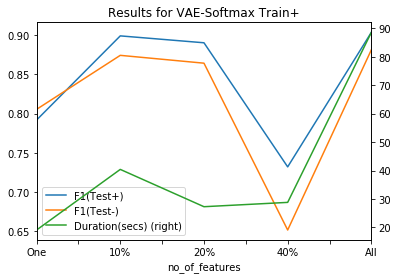

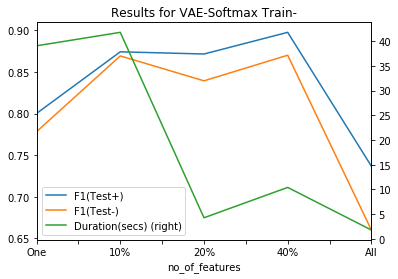

In [7]:
all_scenarios_vae_sm = evaluate("VAE-Softmax", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [8]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-__.pkl")

'Results for VAE-Label Train+'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              1                  2       0.4675      0.5692    0.7255   
24             1                 42       0.5187      0.5800    0.6778   
122            3                 18       0.4937      0.5549    0.6667   
24             3                 12       0.4774      0.4903    0.5610   
48             3                  6       0.4587      0.4525    0.4421   
122            1                 18       0.5217      0.4825    0.3815   
48             1                  2       0.4576      0.4368    0.3570   
12             1                 16       0.5362      0.4312    0.0017   
               3                  3       0.5298      0.4308    0.0003   
1              3                  2       0.5363      0.4308    0.0000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              1                     0.8184       0.9001      1.8554  
24             1                     0.6807       0.7922    120.1837  
122            3                     0.6695       0.7915    158.8168  
24             3                     0.5338       0.6630     73.7889  
48             3                     0.3936       0.4869     19.5371  
122            1                     0.3697       0.4271    136.6352  
48             1                     0.3521       0.4118      3.0059  
12             1                     0.1819       0.0010     39.5257  
               3                     0.1817       0.0002      7.3937  
1              3                     0.1816       0.0000      4.8651

'Results for VAE-Label Train-'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              3                  2       0.4623      0.5692    0.7255   
24             1                 13       0.4012      0.4979    0.6374   
122            1                  3       0.4032      0.4556    0.5413   
48             3                 11       0.5087      0.5397    0.5402   
               1                 14       0.4516      0.4678    0.5295   
12             1                  5       0.5083      0.4410    0.3398   
               3                  2       0.5222      0.4189    0.0762   
24             3                  7       0.5294      0.4329    0.0284   
122            3                 10       0.5357      0.4309    0.0006   
1              1                  2       0.5210      0.4308    0.0000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                     0.8184       0.9001      2.1003  
24             1                     0.6536       0.7816     14.5815  
122            1                     0.5241       0.6541      3.2477  
48             3                     0.5063       0.6203     24.7774  
               1                     0.4884       0.6105     27.9958  
12             1                     0.3230       0.3614      4.6407  
               3                     0.2061       0.0764      2.1936  
24             3                     0.1886       0.0220     14.1130  
122            3                     0.1818       0.0004     47.2732  
1              1                     0.1816       0.0000      1.1337

'Combined Results from all Scenarios for VAE-Label'

Accuracy  Duration(secs)  F1 Score  \
Model     Scenarios    Number of Features                                       
VAE-Label Train+/Test+ 1                     0.5692          1.8554    0.7255   
          Train+/Test- 1                     0.8184          1.8554    0.9001   
          Train-/Test+ 1                     0.5692          2.1003    0.7255   
          Train-/Test- 1                     0.8184          2.1003    0.9001   

                                           Precision  Recall  
Model     Scenarios    Number of Features                     
VAE-Label Train+/Test+ 1                      0.5692     1.0  
          Train+/Test- 1                      0.8184     1.0  
          Train-/Test+ 1                      0.5692     1.0  
          Train-/Test- 1                      0.8184     1.0

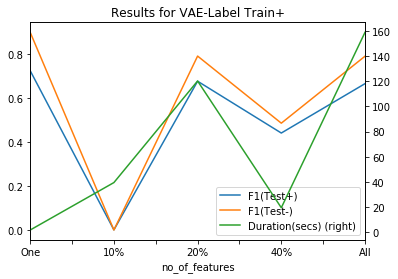

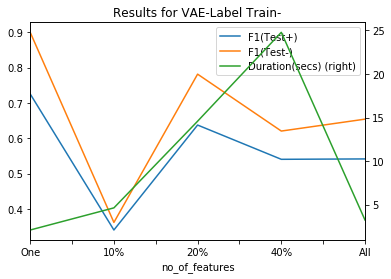

In [9]:
all_scenarios_vae = evaluate("VAE-Label", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [10]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-__.pkl")

'Results for LSTM-Seq2Seq Train+'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              3                 11       1.0000      1.0000     1.000   
               1                 11       0.9997      0.9314     0.937   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                     1.0000       1.0000     24.9541  
               1                     0.8695       0.9153     21.5624

'Results for LSTM-Seq2Seq Train-'

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              3                 11          1.0      1.0000    1.0000   
               1                 11          1.0      0.9186    0.9243   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                     1.0000        1.000     15.2373  
               1                     0.8451        0.898     11.2495

'Combined Results from all Scenarios for LSTM-Seq2Seq'

Accuracy  Duration(secs)  \
Model        Scenarios    Number of Features                             
LSTM-Seq2Seq Train+/Test+ 1                     0.9949         24.9541   
             Train+/Test- 1                     0.9949         24.9541   
             Train-/Test+ 1                     0.9992         15.2373   
             Train-/Test- 1                     0.9992         15.2373   

                                              F1 Score  Precision  Recall  
Model        Scenarios    Number of Features                               
LSTM-Seq2Seq Train+/Test+ 1                     0.9955     0.9915  0.9995  
             Train+/Test- 1                     0.9955     0.9915  0.9995  
             Train-/Test+ 1                     0.9993     0.9985  1.0000  
             Train-/Test- 1                     0.9993     0.9985  1.0000

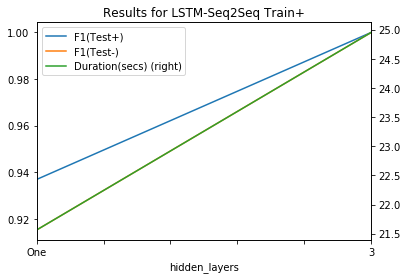

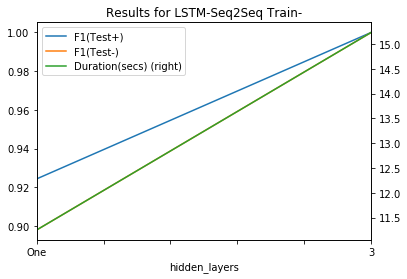

In [11]:
all_scenarios_lstm = evaluate_lstm("LSTM-Seq2Seq", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [12]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae, all_scenarios_vae_sm, all_scenarios_lstm],axis=0)
all_scenarios

,Accuracy,Duration(secs),F1 Score,Model,Number of Features,Precision,Recall,Scenarios
1,0.8670,18.9799,0.8739,FCN,48,0.9490,0.8098,Train+/Test+
1,0.7576,18.9799,0.8350,FCN,48,0.9424,0.7495,Train+/Test-
1,0.8561,0.6421,0.8695,FCN,48,0.8988,0.8420,Train-/Test+
1,0.7504,0.6421,0.8396,FCN,48,0.8856,0.7981,Train-/Test-
1,0.5692,1.8554,0.7255,VAE-Label,1,0.5692,1.0000,Train+/Test+
1,0.8184,1.8554,0.9001,VAE-Label,1,0.8184,1.0000,Train+/Test-
1,0.5692,2.1003,0.7255,VAE-Label,1,0.5692,1.0000,Train-/Test+
1,0.8184,2.1003,0.9001,VAE-Label,1,0.8184,1.0000,Train-/Test-
1,0.8948,88.6219,0.9036,VAE-Softmax,122,0.9441,0.8665,Train+/Test+
1,0.8173,88.6219,0.8814,VAE-Softmax,122,0.9402,0.8296,Train+/Test-


In [28]:
cmap = cm.get_cmap('Blues_r')
matplotlib.style.use('ggplot')
#print(plt.style.available)
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams.update({'figure.autolayout': True})

In [29]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Scenarios', 'Model')
all_scenarios_pivot

Model,FCN,LSTM-Seq2Seq,VAE-Label,VAE-Softmax
Scenarios,,,,
Train+/Test+,0.8739,0.9955,0.7255,0.9036
Train+/Test-,0.8350,0.9955,0.9001,0.8814
Train-/Test+,0.8695,0.9993,0.7255,0.6942
Train-/Test-,0.8396,0.9993,0.9001,0.8700


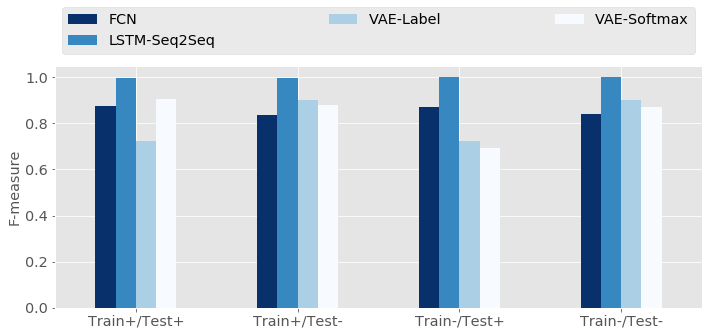

In [38]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='x-large')
lgd = plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
plot_bar.set_xlabel("")
plot_bar.set_ylabel("F-measure", fontsize='x-large')
display_and_save("All Results with Train_Test in X-axis",plot_bar)
#plot_bar.get_figure().savefig("result_plots/fig_a.png", format='png', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [16]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Train+/Test+,Train+/Test-,Train-/Test+,Train-/Test-
Model,,,,
FCN,0.8739,0.8350,0.8695,0.8396
LSTM-Seq2Seq,0.9955,0.9955,0.9993,0.9993
VAE-Label,0.7255,0.9001,0.7255,0.9001
VAE-Softmax,0.9036,0.8814,0.6942,0.8700


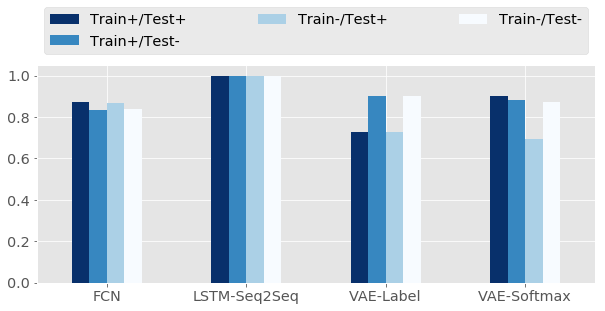

In [17]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='x-large')
plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
plot_bar.set_xlabel("")
display_and_save("All Results with Models in X Axis",plot_bar)


In [41]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'Duration(secs)', 'Model']]
all_scenarios_display.replace('Train+/Test+', 'Train+', inplace=True)
all_scenarios_display.replace('Train+/Test-', 'Train+', inplace=True)
all_scenarios_display.replace('Train-/Test+', 'Train-', inplace=True)
all_scenarios_display.replace('Train-/Test-', 'Train-', inplace=True)

all_scenarios_display

,Scenarios,Duration(secs),Model
1,Train+,18.9799,FCN
1,Train+,18.9799,FCN
1,Train-,0.6421,FCN
1,Train-,0.6421,FCN
1,Train+,1.8554,VAE-Label
1,Train+,1.8554,VAE-Label
1,Train-,2.1003,VAE-Label
1,Train-,2.1003,VAE-Label
1,Train+,88.6219,VAE-Softmax
1,Train+,88.6219,VAE-Softmax


In [42]:
all_scenarios_pivot = all_scenarios_display.pivot_table('Duration(secs)', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Train+,Train-
Model,,
FCN,18.9799,0.6421
LSTM-Seq2Seq,24.9541,15.2373
VAE-Label,1.8554,2.1003
VAE-Softmax,88.6219,10.4086


In [43]:
all_scenarios_pivot = all_scenarios_pivot.reindex(["FCN","VAE-Label","VAE-Softmax", "LSTM-Seq2Seq"])

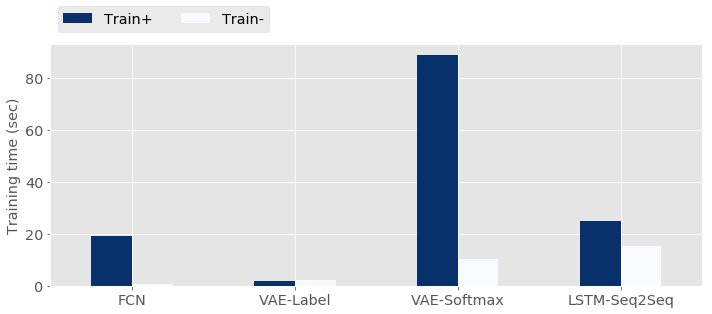

In [44]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='x-large', 
                                    )
lgd = plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, fontsize='x-large')
plot_bar.set_xlabel("")
plot_bar.set_ylabel("Training time (sec)", fontsize='x-large')
display_and_save("All TimeTaken with Models in X Axis",plot_bar)
#plot_bar.get_figure().savefig("result_plots/fig_b.png", format='png', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [22]:
%%bash
zip -r result_plots.zip result_plots

updating: result_plots/ (stored 0%)
updating: result_plots/Results for VAE-GenerateLabels Train-.png (deflated 16%)
updating: result_plots/Results for LSTM Train+.png (deflated 21%)
updating: result_plots/All Results with Models in X Axis.png (deflated 52%)
updating: result_plots/Results for VAE-GenerateLabels Train+.eps (deflated 71%)
updating: result_plots/Results for VAE-Softmax Train+.eps (deflated 70%)
updating: result_plots/All Results with Train_Test in X-axis.png (deflated 53%)
updating: result_plots/Results for VAE-GenerateLabels Train+.png (deflated 15%)
updating: result_plots/Results for VAE-Softmax Train-.eps (deflated 70%)
updating: result_plots/Results for Fully Connected Train+.png (deflated 19%)
updating: result_plots/Results for VAE-Softmax Train+.png (deflated 16%)
updating: result_plots/Results for LSTM Train+.eps (deflated 70%)
updating: result_plots/Results for LSTM Train-.png (deflated 21%)
updating: result_plots/All Results with Models in X Axis.eps (deflated 69%